# Bayesian IGNO: Posterior Sampling with NumPyro

This notebook demonstrates Bayesian uncertainty quantification using the existing J-IGNO codebase.

**Key idea**: Instead of `β* = argmin U(β)`, we sample from `p(β|u_obs) ∝ exp(-U(β))`

The potential energy is:
```
U(β) = F_data + F_pde + F_prior
     = ρ_data·||u_pred - u_obs||²           # Data likelihood
     + ρ_pde·||R||²                          # PDE constraint
     + ½||F_NF(β)||² - log|det J_F(β)|      # Flow prior (this IS the prior!)
```

In [1]:
import load_this_before_everything_else
import sys
sys.path.insert(0, '..')  # Add parent dir to path

import jax
import jax.numpy as jnp
from jax import random, vmap
import numpyro
from numpyro.infer import MCMC, NUTS
import matplotlib.pyplot as plt
import numpy as np

from src.solver.config import TrainingConfig
from src.problems import create_problem

print(f"JAX devices: {jax.devices()}")

JAX devices: [cuda(id=0)]


## 1. Load Trained Model

In [9]:
# Load config and create problem
config = TrainingConfig.load('./configs/evaluation/darcy_continuous_in.yaml')  # Adjust path
problem = create_problem(config, load_train_data=False)

# Initialize and load checkpoint
sample_inputs = problem.get_sample_inputs(batch_size=1)
problem.initialize_models(sample_inputs)
problem.load_checkpoint(config.get_pretrained_path())

params = problem.params
latent_dim = problem.BETA_SIZE
print(f"Loaded model with latent dim: {latent_dim}")

Loading data...
  Test: a=(200, 841, 1), u=(200, 841, 1)
Setting up grids and test functions...
  int_grid: (45, 2), v: (45, 1)
Building models...
Problem initialized (parameters not yet initialized)
  Initialized enc: 116,818 params
  Initialized u: 103,206 params
  Initialized a: 103,206 params
  Initialized nf: 65,604 params
Loading checkpoint: runs/18_dims/weights/best.pt
  Loaded enc
  Loaded u
  Loaded a
  Loaded nf
Loaded model with latent dim: 18


## 2. Prepare Test Data

In [10]:
# Pick a test sample
sample_idx = 0
n_obs = 100
snr_db = None

rng = random.PRNGKey(42)

# Sample observation indices
n_points = problem.get_n_points()
rng, obs_rng = random.split(rng)
obs_indices = problem.sample_observation_indices(
    n_total=n_points,
    n_obs=n_obs,
    method='random',
    rng=obs_rng,
)

# Prepare observations
rng, noise_rng = random.split(rng)
obs_data = problem.prepare_observations(
    sample_indices=[sample_idx],
    obs_indices=obs_indices,
    snr_db=snr_db,
    rng=noise_rng,
)

x_obs = obs_data['x_obs'][0]      # (n_obs, 2)
u_obs = obs_data['u_obs'][0]      # (n_obs, 1)
x_full = obs_data['x_full'][0]    # (n_points, 2)
a_true = obs_data['a_true'][0]    # (n_points, 1)
u_true = obs_data['u_true'][0]    # (n_points, 1)

print(f"Observations: {n_obs} points, SNR={snr_db}dB")

Observations: 100 points, SNR=NonedB


## 3. Define Potential Energy

The potential energy $U(\beta)$ defines our posterior via $p(\beta|u_{obs}) \propto \exp(-U(\beta))$

The **flow prior** is the learned distribution from the normalizing flow:
$$-\log p_{NF}(\beta) = \frac{1}{2}\|F_{NF}(\beta)\|^2 - \log|\det J_F(\beta)|$$

In [14]:
rho_data = 1000.0
rho_pde = 0.0
rho_prior = 0.01
# rho_pde = 1.0
# rho_prior = 0.1

# Fixed RNG for PDE loss (or pass as argument)
pde_rng = random.PRNGKey(0)

def potential_energy(beta):
    beta_batch = beta[None, :]
    x_obs_batch = x_obs[None, :, :]
    u_obs_batch = u_obs[None, :, :]

    # Data term
    F_data = rho_data * problem.loss_data_from_beta(
        params, beta_batch, x_obs_batch, u_obs_batch, target_type='u'
    )

    # PDE term
    # F_pde = rho_pde * problem.loss_pde_from_beta(params, beta_batch, pde_rng)
    F_pde = 0

    # Flow prior
    log_prob = rho_prior * problem.log_prob_latent(params, beta_batch)[0]
    F_prior = -log_prob

    return F_data + F_pde + F_prior

## 4. Run NUTS Sampling

We pass the potential energy directly to NUTS - no need for a NumPyro model since the flow prior is already in `U(β)`.

In [20]:
# Initialize from flow prior: z ~ N(0,I), β = F_NF^{-1}(z)
rng, init_rng = random.split(rng)
beta_init = problem.sample_latent_from_nf(params, 4, init_rng)

print(f"Initial β from flow prior, norm: {float(jnp.linalg.norm(beta_init)):.3f}")
beta_init.shape

(4, 18)

In [21]:
# NUTS with potential_fn - this samples from exp(-potential_energy(β))
kernel = NUTS(
    potential_fn=potential_energy,
    target_accept_prob=0.8,
    max_tree_depth=10,
)

mcmc = MCMC(
    kernel,
    num_warmup=500,
    num_samples=500,
    progress_bar=True,
    num_chains=4
)

# Run with initial position from flow prior
rng, sample_rng = random.split(rng)
mcmc.run(sample_rng, init_params=beta_init)

beta_samples = mcmc.get_samples()
print(f"\nCollected {len(beta_samples)} posterior samples")
print(f"Posterior β mean norm: {float(jnp.linalg.norm(jnp.mean(beta_samples, axis=0))):.3f}")


Collected 2000 posterior samples
Posterior β mean norm: 1.592


In [22]:
# Print MCMC diagnostics
mcmc.print_summary()


                 mean       std    median      5.0%     95.0%     n_eff     r_hat
 Param:0[0]     -0.05      0.61      0.08     -1.34      0.71      3.04      1.77
 Param:0[1]     -0.19      0.36     -0.18     -0.81      0.35      6.22      1.31
 Param:0[2]      0.74      1.15      0.36     -0.50      2.87      2.18      3.54
 Param:0[3]     -0.04      0.53     -0.07     -0.91      0.84      3.73      1.54
 Param:0[4]     -0.55      1.05     -0.14     -2.39      0.72      2.24      3.04
 Param:0[5]     -0.14      0.66     -0.06     -1.19      0.82      2.59      2.13
 Param:0[6]     -0.65      0.78     -0.57     -1.89      0.53      2.99      1.80
 Param:0[7]      0.39      0.87      0.19     -0.78      2.07      2.34      2.88
 Param:0[8]      0.10      0.55      0.09     -0.74      0.93      3.01      1.77
 Param:0[9]      0.37      0.43      0.32     -0.31      0.86      8.09      1.34
Param:0[10]     -0.33      0.69     -0.36     -1.37      0.90      2.51      2.18
Param:0[11]    

## 5. Compute Posterior Statistics

In [23]:
# Decode all β samples to coefficient/solution fields
def decode_sample(beta):
    beta_batch = beta[None, :]
    x_batch = x_full[None, :, :]
    preds = problem.predict_from_beta(params, beta_batch, x_batch)
    return preds['a_pred'][0, :, 0], preds['u_pred'][0, :, 0]

a_samples, u_samples = vmap(decode_sample)(beta_samples)
print(f"Decoded {len(a_samples)} field samples")

# Posterior statistics
a_mean = jnp.mean(a_samples, axis=0)
a_std = jnp.std(a_samples, axis=0)
a_lower = jnp.percentile(a_samples, 2.5, axis=0)
a_upper = jnp.percentile(a_samples, 97.5, axis=0)

u_mean = jnp.mean(u_samples, axis=0)
u_std = jnp.std(u_samples, axis=0)

Decoded 2000 field samples


In [24]:
# Metrics
a_true_flat = a_true[:, 0]
u_true_flat = u_true[:, 0]

# RMSE
a_rmse = jnp.sqrt(jnp.mean((a_mean - a_true_flat)**2))
u_rmse = jnp.sqrt(jnp.mean((u_mean - u_true_flat)**2))

# Coverage (% of true values inside 95% CI)
a_coverage = jnp.mean((a_true_flat >= a_lower) & (a_true_flat <= a_upper))

print(f"Coefficient a:")
print(f"  RMSE:     {float(a_rmse):.4f}")
print(f"  Coverage: {float(a_coverage):.1%}")
print(f"\nSolution u:")
print(f"  RMSE:     {float(u_rmse):.4f}")

Coefficient a:
  RMSE:     0.6569
  Coverage: 49.0%

Solution u:
  RMSE:     0.0024


## 6. Visualization

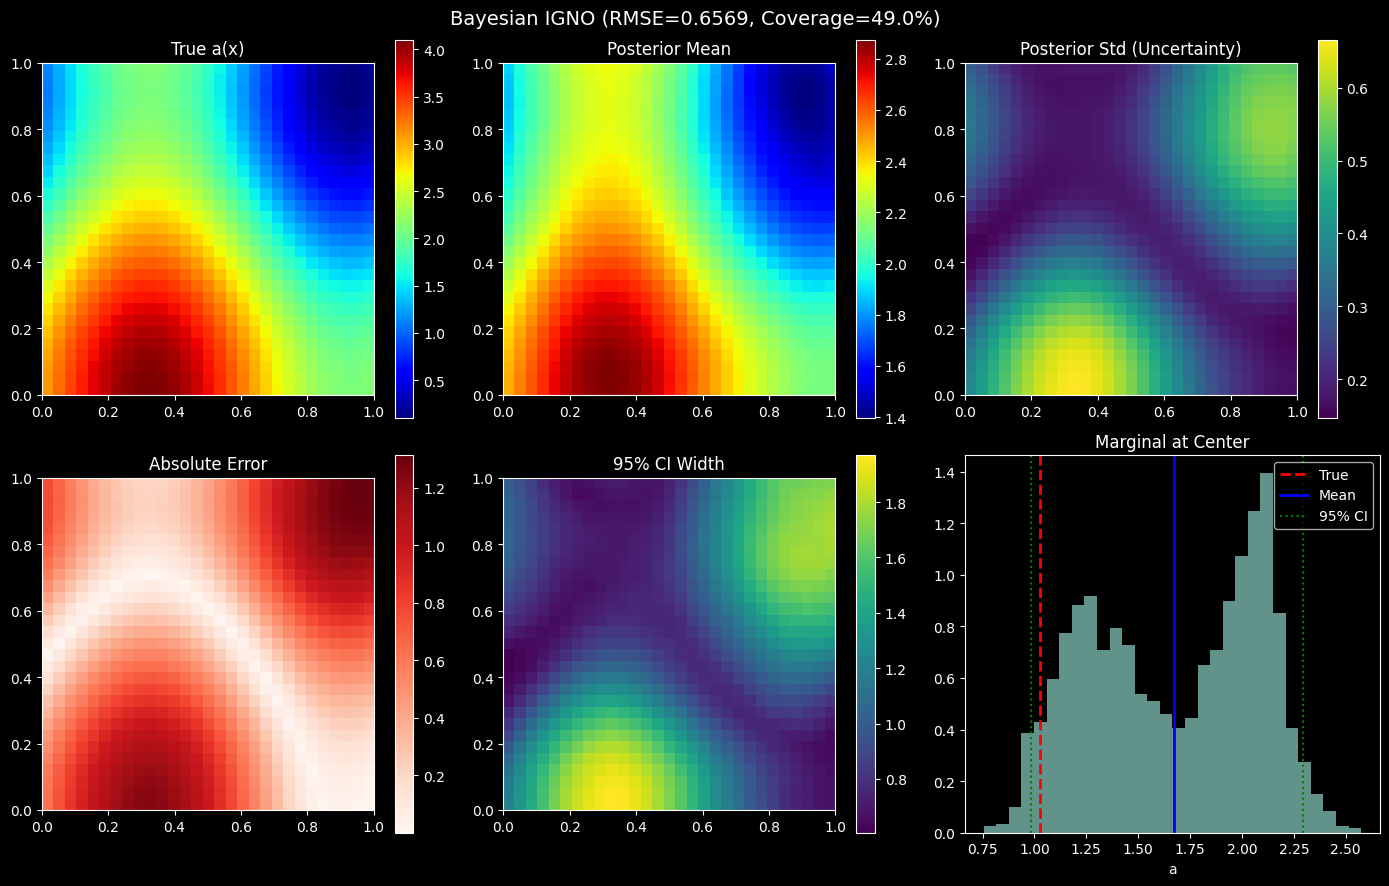

In [25]:
n_grid = int(np.sqrt(len(a_mean)))

fig, axes = plt.subplots(2, 3, figsize=(14, 9))

# Row 1: Coefficient field
im = axes[0,0].imshow(np.array(a_true_flat).reshape(n_grid, n_grid), 
                       origin='lower', extent=[0,1,0,1], cmap='jet')
axes[0,0].set_title('True a(x)')
plt.colorbar(im, ax=axes[0,0])

im = axes[0,1].imshow(np.array(a_mean).reshape(n_grid, n_grid),
                       origin='lower', extent=[0,1,0,1], cmap='jet')
axes[0,1].set_title('Posterior Mean')
plt.colorbar(im, ax=axes[0,1])

im = axes[0,2].imshow(np.array(a_std).reshape(n_grid, n_grid),
                       origin='lower', extent=[0,1,0,1], cmap='viridis')
axes[0,2].set_title('Posterior Std (Uncertainty)')
plt.colorbar(im, ax=axes[0,2])

# Row 2: Error and diagnostics
error = np.abs(np.array(a_mean - a_true_flat))
im = axes[1,0].imshow(error.reshape(n_grid, n_grid),
                       origin='lower', extent=[0,1,0,1], cmap='Reds')
axes[1,0].set_title('Absolute Error')
plt.colorbar(im, ax=axes[1,0])

ci_width = np.array(a_upper - a_lower)
im = axes[1,1].imshow(ci_width.reshape(n_grid, n_grid),
                       origin='lower', extent=[0,1,0,1], cmap='viridis')
axes[1,1].set_title('95% CI Width')
plt.colorbar(im, ax=axes[1,1])

# Marginal histogram at center point
center_idx = n_grid * n_grid // 2 + n_grid // 2
axes[1,2].hist(np.array(a_samples[:, center_idx]), bins=30, density=True, alpha=0.7)
axes[1,2].axvline(float(a_true_flat[center_idx]), color='r', linestyle='--', lw=2, label='True')
axes[1,2].axvline(float(a_mean[center_idx]), color='b', lw=2, label='Mean')
axes[1,2].axvline(float(a_lower[center_idx]), color='g', linestyle=':', lw=1.5, label='95% CI')
axes[1,2].axvline(float(a_upper[center_idx]), color='g', linestyle=':', lw=1.5)
axes[1,2].legend()
axes[1,2].set_title('Marginal at Center')
axes[1,2].set_xlabel('a')

plt.suptitle(f'Bayesian IGNO (RMSE={float(a_rmse):.4f}, Coverage={float(a_coverage):.1%})', fontsize=14)
plt.tight_layout()
plt.savefig('bayesian_igno_results.png', dpi=150)
plt.show()

## 7. Compare with Point Estimation (Standard IGNO)

In [26]:
from src.evaluation import IGNOInverter

# Run standard gradient-based inversion
rng, inv_rng = random.split(rng)
inverter = IGNOInverter(problem, inv_rng)

beta_point = inverter.invert(
    x_obs=x_obs[None, :, :],
    u_obs=u_obs[None, :, :],
    x_full=x_full[None, :, :],
    config=config.evaluation.inversion,
    verbose=True,
)[0]

# Decode point estimate
a_point, u_point = decode_sample(beta_point)
rmse_point = jnp.sqrt(jnp.mean((a_point - a_true_flat)**2))

print(f"\n" + "="*50)
print(f"Point estimation RMSE: {float(rmse_point):.4f}")
print(f"Bayesian mean RMSE:    {float(a_rmse):.4f}")
print(f"\nBayesian provides {float(a_coverage):.0%} coverage")
print(f"Point estimation provides NO uncertainty!")
print("="*50)


beta_batch = beta_point[None, :]
x_obs_batch = x_obs[None, :, :]
u_obs_batch = u_obs[None, :, :]

F_data = 500.0 * problem.loss_data_from_beta(params, beta_batch, x_obs_batch, u_obs_batch, 'u')
F_pde = 1.0 * problem.loss_pde_from_beta(params, beta_batch, pde_rng)
log_prob = problem.log_prob_latent(params, beta_batch)[0]
F_prior = 0.05 * -log_prob

print(f"F_data: {float(F_data):.4f}")
print(f"F_pde:  {float(F_pde):.4f}")
print(f"F_prior: {float(F_prior):.4f}")
print(f"Total U: {float(F_data + F_pde + F_prior):.4f}")

F_data: 1.8021
F_pde:  0.6145
F_prior: 10.6318
Total U: 13.0484


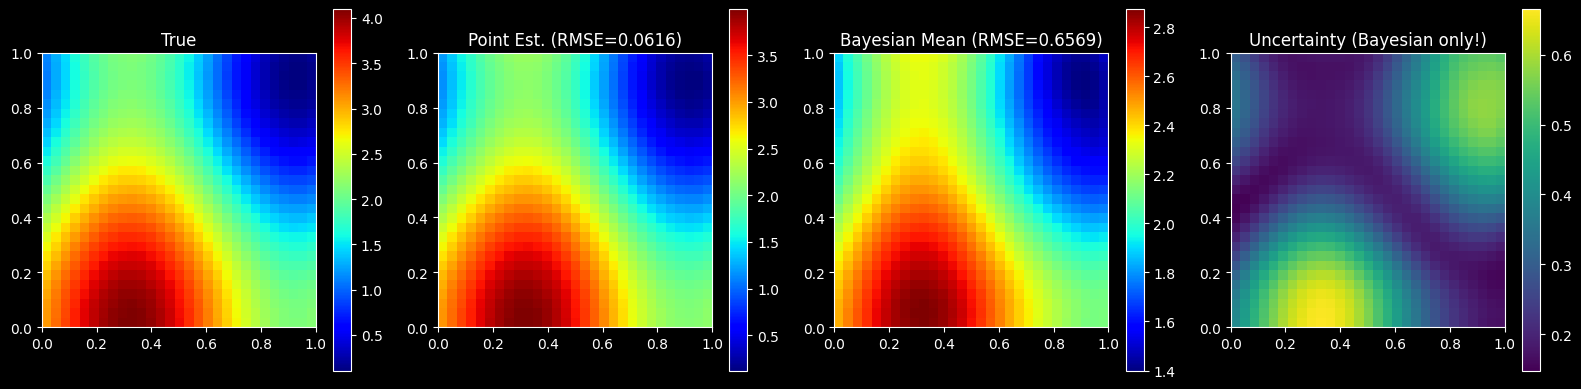

In [27]:
# Side-by-side comparison
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

im = axes[0].imshow(np.array(a_true_flat).reshape(n_grid, n_grid),
                     origin='lower', extent=[0,1,0,1], cmap='jet')
axes[0].set_title('True')
plt.colorbar(im, ax=axes[0])

im = axes[1].imshow(np.array(a_point).reshape(n_grid, n_grid),
                     origin='lower', extent=[0,1,0,1], cmap='jet')
axes[1].set_title(f'Point Est. (RMSE={float(rmse_point):.4f})')
plt.colorbar(im, ax=axes[1])

im = axes[2].imshow(np.array(a_mean).reshape(n_grid, n_grid),
                     origin='lower', extent=[0,1,0,1], cmap='jet')
axes[2].set_title(f'Bayesian Mean (RMSE={float(a_rmse):.4f})')
plt.colorbar(im, ax=axes[2])

im = axes[3].imshow(np.array(a_std).reshape(n_grid, n_grid),
                     origin='lower', extent=[0,1,0,1], cmap='viridis')
axes[3].set_title('Uncertainty (Bayesian only!)')
plt.colorbar(im, ax=axes[3])

plt.tight_layout()
plt.savefig('point_vs_bayesian.png', dpi=150)
plt.show()

## 8. Posterior Samples Gallery

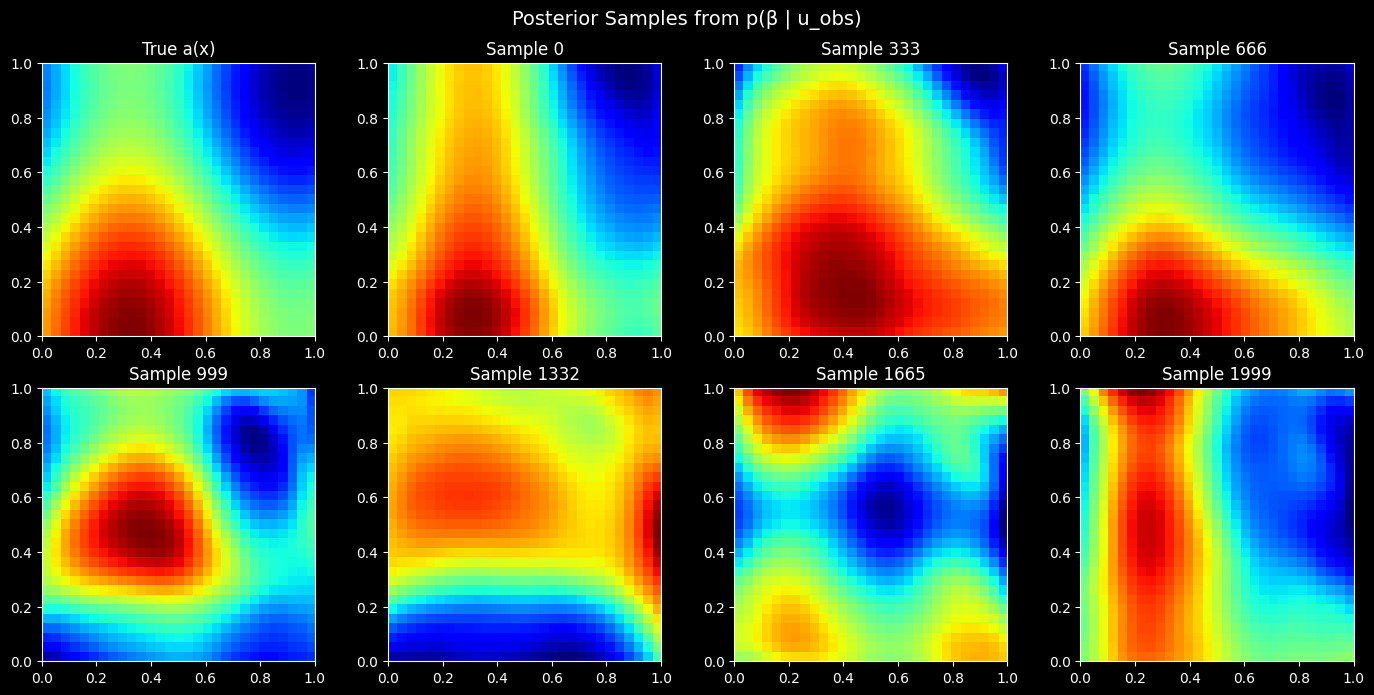

In [17]:
# Show some posterior samples
fig, axes = plt.subplots(2, 4, figsize=(14, 7))

# First: true field
im = axes[0,0].imshow(np.array(a_true_flat).reshape(n_grid, n_grid),
                       origin='lower', extent=[0,1,0,1], cmap='jet')
axes[0,0].set_title('True a(x)')

# Then: 7 posterior samples
sample_indices = np.linspace(0, len(a_samples)-1, 7, dtype=int)
for idx, (ax, si) in enumerate(zip(axes.flat[1:], sample_indices)):
    im = ax.imshow(np.array(a_samples[si]).reshape(n_grid, n_grid),
                   origin='lower', extent=[0,1,0,1], cmap='jet')
    ax.set_title(f'Sample {si}')

plt.suptitle('Posterior Samples from p(β | u_obs)', fontsize=14)
plt.tight_layout()
plt.show()